# Import Library

In [4]:
import os
import cv2
import csv
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Setup Dataset

In [13]:
# Paths
data_path = "/kaggle/input/ff-c23/FaceForensics++_C23"
output_dir = "frames_cropped_new"
os.makedirs(output_dir, exist_ok=True)

# Debug settings
DEBUG_MODE = True
DEBUG_VIDEOS_PER_CATEGORY = 1000  # number of videos per category to debug

# NEW: maksimum crops per video
MAX_CROPS_PER_VIDEO = 1

# Category-to-label mapping
categories = {
    "original": 0,
    "DeepFakeDetection": 1,
    "Deepfakes": 1,
    "Face2Face": 1,
    "FaceSwap": 1,
    "FaceShifter":1,
    "NeuralTextures": 1
}

# Cropping Face

In [14]:
# Initialize face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

# Prepare CSV rows
csv_rows = [["filepath", "label"]]

# Loop through each category and video
for category, label in tqdm(categories.items(),desc="categories"):
    print(f"\nCategory: {category}")
    processed_count = 0
    cat_path = os.path.join(data_path, category)

    for root, _, files in os.walk(cat_path):
        for file in files:
            if not file.endswith('.mp4'):
                continue
            if DEBUG_MODE and processed_count >= DEBUG_VIDEOS_PER_CATEGORY:
                break

            video_path = os.path.join(root, file)
            # print(f"Processing video: {video_path}")

            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS) or 30
            interval = int(fps)  # 1 frame per second
            frame_idx = 0
            saved_idx = 0

            while True:
                ret, frame = cap.read()
                if not ret or saved_idx >= MAX_CROPS_PER_VIDEO:
                    # berhenti jika video habis atau sudah mencapai batas crop
                    break

                # Only process one frame per second
                if frame_idx % interval == 0:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
                    if len(faces) > 0:
                        x, y, w, h = faces[0]  # ambil wajah pertama
                        face_crop = frame[y:y+h, x:x+w]
                        save_fname = f"{category}_{os.path.splitext(file)[0]}_{saved_idx:04d}.jpg"
                        save_path = os.path.join(output_dir, save_fname)
                        cv2.imwrite(save_path, face_crop)
                        csv_rows.append([save_path, label])
                        saved_idx += 1

                frame_idx += 1

            cap.release()
            processed_count += 1

        if DEBUG_MODE and processed_count >= DEBUG_VIDEOS_PER_CATEGORY:
            break

# Write out the labels CSV
with open("labels.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

print("\nDone! Cropped frames saved in", output_dir)
print("Labels list saved to labels.csv")

categories:   0%|          | 0/7 [00:00<?, ?it/s]


Category: original

Category: DeepFakeDetection

Category: Deepfakes

Category: Face2Face

Category: FaceSwap

Category: FaceShifter

Category: NeuralTextures

Done! Cropped frames saved in frames_cropped_new
Labels list saved to labels.csv


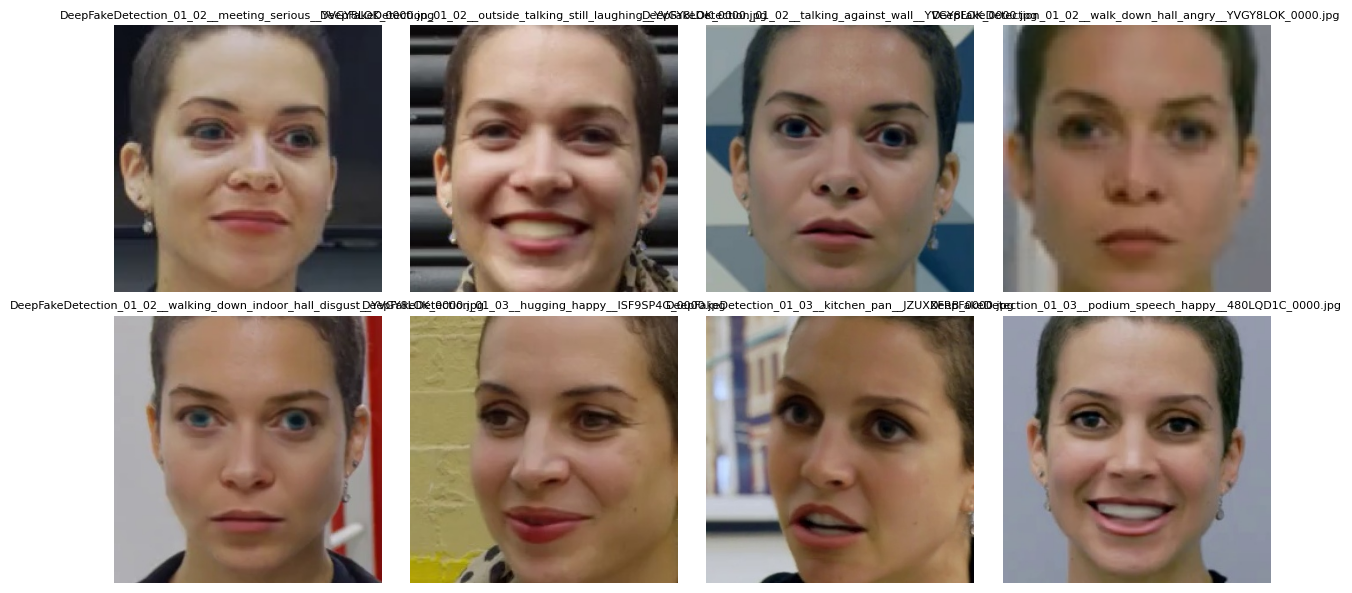

In [18]:
# Lokasi folder hasil crop
output_dir = "frames_cropped_new"

# Atur berapa banyak gambar yang mau ditampilkan
NUM_IMAGES = 8
COLS = 4

# Ambil dan sort file JPG
all_imgs = sorted([f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')])
sample = all_imgs[:NUM_IMAGES]

# Hitung jumlah baris agar pas
rows = (len(sample) + COLS - 1) // COLS

# Setup figure
plt.figure(figsize=(COLS * 3, rows * 3))

# Loop dan tampilkan
for idx, fname in enumerate(sample):
    img_path = os.path.join(output_dir, fname)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.subplot(rows, COLS, idx + 1)
    plt.imshow(img_rgb)
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
df = pd.read_csv('labels.csv')
print(f"Label unique : {df['label'].unique()}\n")
print(f"Label Count: {df['label'].value_counts()}\n")
df.info()

Label unique : [0 1]

Label Count: label
1    5974
0    1000
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6974 entries, 0 to 6973
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  6974 non-null   object
 1   label     6974 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.1+ KB


In [21]:
import zipfile
import os

# Define the paths to your output directory and CSV file
output_dir = 'frames_cropped_new'  # Directory where cropped images are stored
csv_file = 'labels.csv'  # CSV file containing the labels

# Define the zip file path
zip_file_path = '/kaggle/working/output_dataset.zip'

# Create a zip file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add all the files in the output directory to the zip file
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))
    
    # Add the CSV file to the zip file
    zipf.write(csv_file, os.path.basename(csv_file))

print(f'Zipped the output folder and CSV to {zip_file_path}')


Zipped the output folder and CSV to /kaggle/working/output_dataset.zip


# CNN

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set paths
image_dir = 'frames_cropped_new'  # Directory where cropped images are stored
labels_file = 'labels.csv'  # File containing image paths and labels

# Load labels from CSV file
labels_df = pd.read_csv(labels_file)

# Prepare images and labels
images = []
labels = []


2025-05-27 17:00:27.892998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748365228.199713      96 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748365228.289203      96 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

for index, row in labels_df.iterrows():
    image_path = row['filepath']
    label = row['label']
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize to fixed size (128x128 for example)
    img = img / 255.0  # Normalize image
    
    images.append(img)
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# One-hot encode labels
labels = to_categorical(labels, num_classes=len(labels_df['label'].unique()))

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation (optional)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:

# Build CNN model
# Build simpler CNN model
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(labels_df['label'].unique()), activation='softmax'))  # Output layer

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 17:01:05.886229: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:

# Train the model
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

# Save the model
model.save('cnn_face_classifier.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 288ms/step - accuracy: 0.8359 - loss: 0.5683 - val_accuracy: 0.8545 - val_loss: 0.4237
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 50s 285ms/step - accuracy: 0.8533 - loss: 0.4390 - val_accuracy: 0.8545 - val_loss: 0.4183
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - accuracy: 0.8624 - loss: 0.4086 - val_accuracy: 0.8545 - val_loss: 0.4166
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - accuracy: 0.8572 - loss: 0.4118 - val_accuracy: 0.8545 - val_loss: 0.4227
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 49s 282ms/step - accuracy: 0.8544 - loss: 0.4167 - val_accuracy: 0.8545 - val_loss: 0.4131
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 49s 276ms/step - accuracy: 0.8627 - loss: 0.4016 - val_accuracy: 0.8545 - val_loss: 0.4118
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.8620 - loss: 0.4076 - val_accuracy: 0.8545 - val_loss: 0.4115
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 275ms/step - accuracy: 0.8648 - loss: 0

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


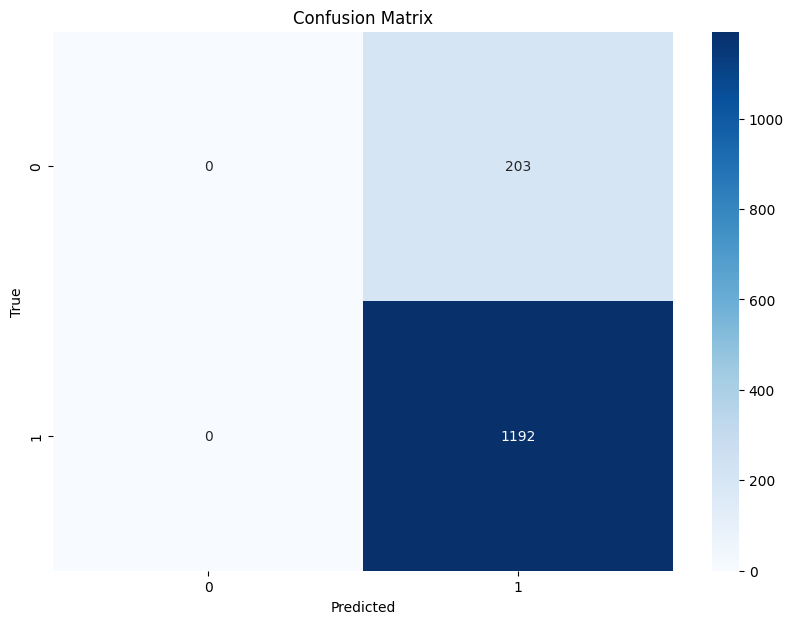

In [7]:

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from one-hot to integer labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_df['label'].unique(), yticklabels=labels_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
model.save('cnn_face_classifier.h5') 